In [72]:
#Load all necessary qiskit and generic libraries

from qiskit import Aer, transpile, assemble
from qiskit.circuit.library import QFT
from qiskit.aqua import QuantumInstance, aqua_globals
from qiskit.quantum_info import state_fidelity
from qiskit.aqua.algorithms import HHL, NumPyLSsolver
from qiskit.aqua.components.eigs import EigsQPE
from qiskit.aqua.components.reciprocals import LookupRotation
from qiskit.aqua.operators import MatrixOperator
from qiskit.aqua.components.initial_states import Custom
from qiskit.tools.visualization import circuit_drawer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.visualization import plot_histogram
from qiskit.tools.visualization import circuit_drawer
from qiskit import execute
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline


#Initliaze Simulator
from qiskit import BasicAer
backend = BasicAer.get_backend('statevector_simulator')


In [73]:
def binaryToPhase(binary):
    binary=list(binary[::-1])
    length = len(binary)
    res=0
    
    for i in range(length):
        digit=int(binary.pop())
        if digit==1:
            res=res+pow(2,i)  
    return res

In [74]:
#Function for calling the EigsQpe with minimal values and default most of the values

def create_eigs(matrix, num_ancillae, negative_evals, evo_time=None):
    ne_qfts = [None, None]
    if negative_evals:
        num_ancillae += 1
        ne_qfts = [QFT(num_ancillae - 1), QFT(num_ancillae - 1).inverse()]

    return EigsQPE(MatrixOperator(matrix=matrix),
                   QFT(num_ancillae).inverse(),
                   num_time_slices=1,
                   num_ancillae=num_ancillae,
                   expansion_mode='trotter',
                   expansion_order=1,
                   evo_time=evo_time,
                   negative_evals=negative_evals,
                   ne_qfts=ne_qfts)


In [75]:
def process_results(circuit,scale,nqbit,cdict,plothist=True):
    
    ndict={}
    
    for kval in cdict.keys():
        nkey=kval[1:]
        ndict[nkey]=cdict[kval]
        
    print('\nActual Eigen Value from Circuit:')
    
    for kval in ndict.keys():
        theta=binaryToPhase(kval)
        
        eigen=(2*np.pi*theta)/((2**nqbit)*scale)
        print(eigen)
        
    return ndict,circuit

In [76]:
def execute_eigs(matrix,nqubits,negativeEigen):
    #Initialize circuit
    q = QuantumRegister(1)
    qc = QuantumCircuit(q)
    
    # State preparation
    qc.x(q[0])
    qc.h(q[0])
    
    e,v=np.linalg.eig(matrix)
    print('Expected Eigen Values:',e)
    
    eigs = create_eigs(matrix, nqubits, negativeEigen)
    num_q, num_a = eigs.get_register_sizes()
    qc += eigs.construct_circuit("circuit", q)
    
    scale=eigs.get_scaling()

    result = execute(qc,backend).result()
    counts = result.get_counts()

    res=sorted(counts.items(), key = lambda kv:(kv[1], kv[0]),reverse=True)
    
    
    rdict=dict(res[:2])
    print('\nCounts:',rdict)
    return process_results(qc,scale,nqubits,rdict,plothist=True)

In [77]:
A=[[1,-1/3],[-1/3,1]]
count,circuit=execute_eigs(matrix=A,nqubits=7,negativeEigen=False)

Expected Eigen Values: [1.33333333 0.66666667]

Counts: {'11111111': 0.499999999999994, '11111110': 0.499999999999994}

Actual Eigen Value from Circuit:
1.3333333333333333
0.6614173228346456


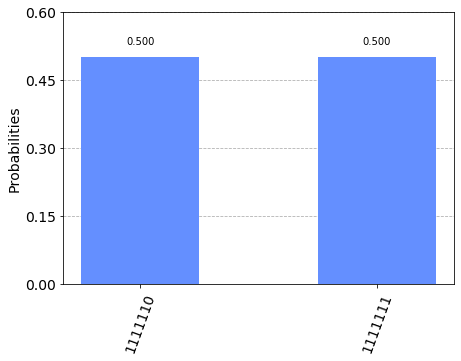

In [78]:
plot_histogram(count)

In [79]:
circuit.draw()

┌───┐┌───┐┌─────────────────────────┐             »
q1298_0: ┤ X ├┤ H ├┤0                        ├─────────────»
         ├───┤└───┘│  Controlled-Evolution^1 │┌───────────┐»
q1299_0: ┤ H ├─────┤1                        ├┤ P(4.6756) ├»
         ├───┤     └─────────────────────────┘└───────────┘»
q1299_1: ┤ H ├─────────────────────────────────────────────»
         ├───┤                                             »
q1299_2: ┤ H ├─────────────────────────────────────────────»
         ├───┤                                             »
q1299_3: ┤ H ├─────────────────────────────────────────────»
         ├───┤                                             »
q1299_4: ┤ H ├─────────────────────────────────────────────»
         ├───┤                                             »
q1299_5: ┤ H ├─────────────────────────────────────────────»
         ├───┤                                             »
q1299_6: ┤ H ├─────────────────────────────────────────────»
         └───┘                                             »
«         ┌─────────────────────────┐             ┌─────────────────────────┐»
«q1298_0: ┤0                        ├─────────────┤0                        ├»
«         │                         │             │                         │»
«q1299_0: ┤  Controlled-Evolution^2 ├─────────────┤                         ├»
«         │                         │┌───────────┐│  Controlled-Evolution^4 │»
«q1299_1: ┤1                        ├┤ P(9.3511) ├┤                         ├»
«         └─────────────────────────┘└───────────┘│                         │»
«q1299_2: ────────────────────────────────────────┤1                        ├»
«                                                 └─────────────────────────┘»
«q1299_3: ───────────────────────────────────────────────────────────────────»
«                                                                            »
«q1299_4: ───────────────────────────────────────────────────────────────────»
«                                                                            »
«q1299_5: ───────────────────────────────────────────────────────────────────»
«                                                                            »
«q1299_6: ───────────────────────────────────────────────────────────────────»
«                                                                            »
«                      ┌─────────────────────────┐             »
«q1298_0: ─────────────┤0                        ├─────────────»
«                      │                         │             »
«q1299_0: ─────────────┤                         ├─────────────»
«                      │                         │             »
«q1299_1: ─────────────┤  Controlled-Evolution^8 ├─────────────»
«         ┌───────────┐│                         │             »
«q1299_2: ┤ P(18.702) ├┤                         ├─────────────»
«         └───────────┘│                         │┌───────────┐»
«q1299_3: ─────────────┤1                        ├┤ P(37.405) ├»
«                      └─────────────────────────┘└───────────┘»
«q1299_4: ─────────────────────────────────────────────────────»
«                                                              »
«q1299_5: ─────────────────────────────────────────────────────»
«                                                              »
«q1299_6: ─────────────────────────────────────────────────────»
«                                                              »
«         ┌──────────────────────────┐             ┌──────────────────────────┐»
«q1298_0: ┤0                         ├─────────────┤0                         ├»
«         │                          │             │                          │»
«q1299_0: ┤                          ├─────────────┤                          ├»
«         │                          │             │                          │»
«q1299_1: ┤                          ├─────────────┤                          ├»
«         │  Controlled-Evolution^16 │

In [80]:
A=[[1,-1/2],[-1/2,1]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1, -0.5], [-0.5, 1]] 

Expected Eigen Values: [1.5 0.5]

Counts: {'111': 0.500000000000001, '110': 0.500000000000001}

Actual Eigen Value from Circuit:
1.5
0.5


In [85]:
A = [[1.5, 0.5], [0.5, 1.5]]

print('Matrix:\n',A,'\n')
count,circuit=execute_eigs(matrix=A,nqubits=2,negativeEigen=False)

Matrix:
 [[1.5, 0.5], [0.5, 1.5]] 

Expected Eigen Values: [2. 1.]

Counts: {'011': 0.213388347648319, '010': 0.213388347648319}

Actual Eigen Value from Circuit:
2.0
0.6666666666666666
